# Building CNN model for predicting MOE and MOR of wood in the transverse direction

## 1. import all necessary libraries

In [1]:
from common.modules import *

2023-06-09 10:49:05.276036: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## 2. read database

In [2]:
h5_path_ = "database.h5"
f = h5py.File(h5_path_, 'r')
mydata=hdfRead()
_, dat=mydata.list_contents(f)

temp=[fl for fl in dat if 'static/' in fl]
img_path=[fl for fl in temp if 'img' in fl]

## 3. Train MOE

In [3]:
X = []
Y = []

for i in range(len(img_path)):
    img=f[img_path[i]]
    X.append(standardize(np.asarray(img)))
    Y.append(f[img_path[i]].attrs['MOE'])  #<KeysViewHDF5 ['MOE', 'MOR']>

X = np.asarray(X)
Y = np.asarray(Y)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(np.asarray(X), np.asarray(Y), test_size=0.2, random_state=0)

In [5]:
model = model(X_train)

2023-06-09 10:45:04.147398: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 10:45:05.006116: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11418 MB memory:  -> device: 0, name: NVIDIA TITAN Xp COLLECTORS EDITION, pci bus id: 0000:1a:00.0, compute capability: 6.1
2023-06-09 10:45:05.006752: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11406 MB memory:  -> device: 1, name: NVIDIA TITAN Xp COLLECTORS EDITION, pci bus id: 0000:68:00.0, compute capability: 6.1


In [6]:
checkpoint_filepath = 'model_MOE.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=True,
                                                               save_best_only=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse',optimizer=optimizer,metrics=['mse','mae'])

history = model.fit(X_train, y_train, validation_split=0.1, verbose=0, epochs=1000, callbacks=[model_checkpoint_callback, PrintDot()])

2023-06-09 10:02:29.426850: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
................................................................................

In [8]:
model.load_weights('model_MOE.h5')
train_predictions = model.predict(X_train).flatten()
test_predictions = model.predict(X_test).flatten()

r2 = r2_score(y_test, test_predictions)
rmse = mean_squared_error(y_test, test_predictions, squared=False)

2/2 [==============================] - 0s 11ms/step


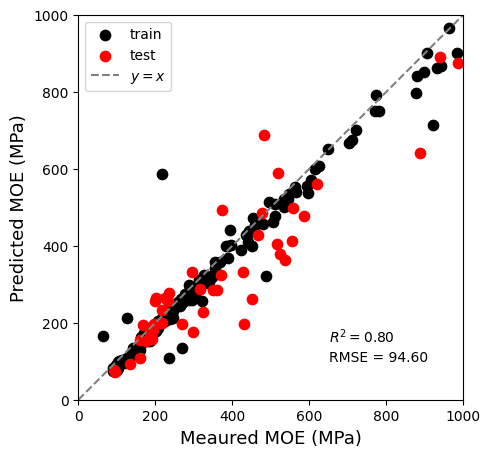

In [9]:
plt.figure(figsize=(5,5))
plt.scatter(y_train, train_predictions,color='black', label='train', s=55)
plt.scatter(y_test, test_predictions, color='red', label='test', s=55)
plt.xlabel('Meaured MOE (MPa)', fontsize=13)
plt.ylabel('Predicted MOE (MPa)', fontsize=13)
plt.axis('equal')
plt.axis('square')
plt.text(650,100,'RMSE = ' + str('%.2f'%rmse))
plt.text(650,150,'$R^2 = $' + str('%.2f'%r2))
plt.xlim([0,1000])
plt.ylim([0,1000])
_ = plt.plot([0, 1000], [0, 1000], linestyle='--', color='gray', label="$y = x$")
plt.legend()

## 4. Train MOE with informing density

In [10]:
X1 = []
X2 = []
Y = []

for i in range(len(img_path)):
    img=f[img_path[i]]
    X1.append(standardize(np.asarray(img)))
    X2.append(f[img_path[i]].attrs['Density'])
    Y.append(f[img_path[i]].attrs['MOE'])

X1 = np.asarray(X)
X2 = standardize(np.asarray(X2))
Y = np.asarray(Y)

In [11]:
X_train_1, X_test_1, X_train_2, X_test_2, y_train, y_test = train_test_split(np.asarray(X1), np.asarray(X2), np.asarray(Y), test_size=0.2, random_state=0)

In [12]:
model_1 = model_1(X_train_1)

In [14]:
checkpoint_filepath = 'model_MOE_density.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=True,
                                                               save_best_only=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_1.compile(loss='mse',optimizer=optimizer,metrics=['mse','mae'])

history = model_1.fit([X_train_1, X_train_2], y_train, epochs=1000, verbose=0, validation_split = 0.1, callbacks=[model_checkpoint_callback, PrintDot()])

 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
................................................................................

In [13]:
model_1.load_weights('model_MOE_density.h5')
test_predictions = model_1.predict([X_test_1, X_test_2]).flatten()
train_predictions = model_1.predict([X_train_1, X_train_2]).flatten()

r2 = r2_score(y_test, test_predictions)
rmse = mean_squared_error(y_test, test_predictions, squared=False)

6/6 [==============================] - 0s 13ms/step


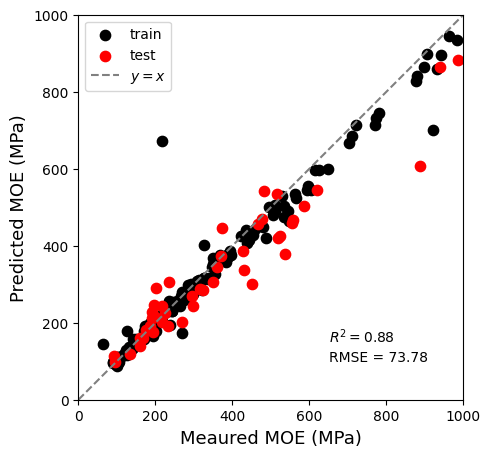

In [14]:
plt.figure(figsize=(5,5))
plt.scatter(y_train, train_predictions,color='black', label='train', s=55)
plt.scatter(y_test, test_predictions, color='red', label='test', s=55)
plt.xlabel('Meaured MOE (MPa)', fontsize=13)
plt.ylabel('Predicted MOE (MPa)', fontsize=13)
plt.axis('equal')
plt.axis('square')
plt.text(650,100,'RMSE = ' + str('%.2f'%rmse))
plt.text(650,150,'$R^2 = $' + str('%.2f'%r2))
plt.xlim([0,1000])
plt.ylim([0,1000])
_ = plt.plot([0, 1000], [0, 1000], linestyle='--', color='gray', label="$y = x$")
plt.legend()